# TP05: Function Approximation and Control

In this notebook you will learn how to:
- Use function approximation in the control setting
- Implement the Sarsa algorithm using tile coding
- Compare three settings for tile coding to see their effect on our agent



In [1]:
# Clone repository, necessary for importing modules to Colab
import os
from subprocess import getoutput
getoutput("git clone -l -s https://gitlab-research.centralesupelec.fr/othmane.laousy/tp05_value_function_approximation tp05_value_function_approximation")
os.chdir("tp05_value_function_approximation")

In [2]:
# Import Necessary Libraries
import numpy as np
import itertools
import matplotlib.pyplot as plt
import tiles3 as tc
from rl_glue import RLGlue
from agent import BaseAgent
from utils import argmax
import mountaincar_env
import time

In the above cell, we import the libraries we need for this assignment. You may have noticed that we import mountaincar_env. This is the __Mountain Car Task__ introduced in [Section 10.1 of the textbook](http://www.incompleteideas.net/book/RLbook2018.pdf#page=267). The task is for an under powered car to make it to the top of a hill:
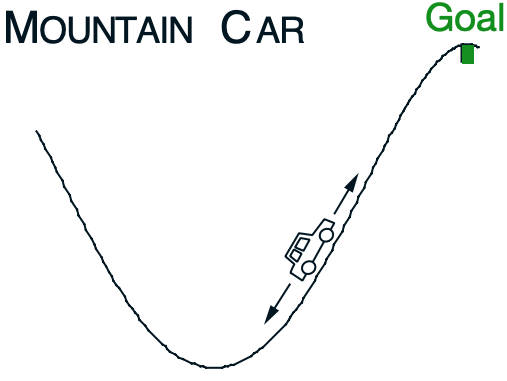

The car is under-powered so the agent needs to learn to rock back and forth to get enough momentum to reach the goal. At each time step the agent receives from the environment its current velocity (a float between -0.07 and 0.07), and it's current position (a float between -1.2 and 0.5). Because our state is continuous there are a potentially infinite number of states that our agent could be in. We need a function approximation method to help the agent deal with this. In this notebook we will use tile coding. We provide a tile coding implementation for you to use, imported above with tiles3.

## Section 1: Tile Coding Helper Function

To begin we are going to build a tile coding class for our Sarsa agent that will make it easier to make calls to our tile coder.

### Tile Coding Function

Tile coding is introduced in [Section 9.5.4 of the textbook](http://www.incompleteideas.net/book/RLbook2018.pdf#page=239) of the textbook as a way to create features that can both provide good generalization and discrimination. It consists of multiple overlapping tilings, where each tiling is a partitioning of the space into tiles.
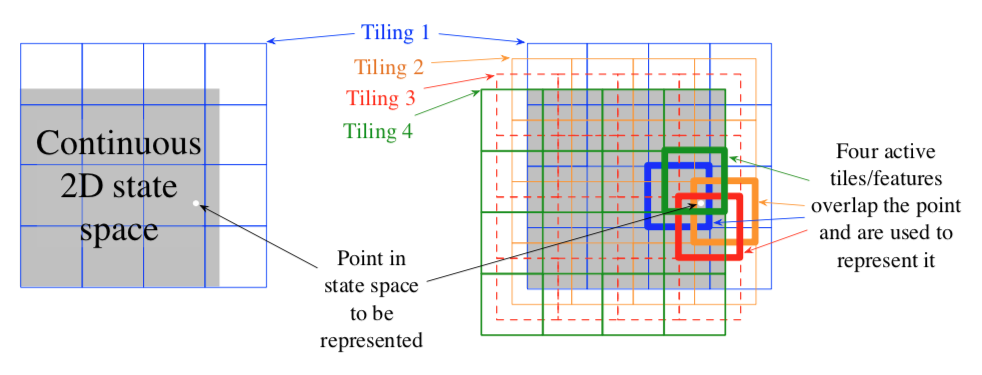


To help keep our agent code clean we are going to make a function specific for tile coding for our Mountain Car environment. To help we are going to use the Tiles3 library. This is a Python 3 implementation of the tile coder. To start take a look at the documentation: [Tiles3 documentation](http://incompleteideas.net/tiles/tiles3.html)
To get the tile coder working we need to implement a few pieces:
- First: create an index hash table - this is done for you in the init function using tc.IHT.
- Second is to scale the inputs for the tile coder based on the number of tiles and the range of values each input could take. The tile coder needs to take in a number in range [0, 1], or scaled to be [0, 1] * num_tiles. For more on this refer to the [Tiles3 documentation](http://incompleteideas.net/tiles/tiles3.html).
- Finally we call tc.tiles to get the active tiles back.

In [3]:
# [Graded]
class MountainCarTileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8):
        """
        Initializes the MountainCar Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the
                     tile coder are the same
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        self.iht = tc.IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
    
    def get_tiles(self, position, velocity):
        """
        Takes in a position and velocity from the mountaincar environment
        and returns a numpy array of active tiles.
        
        Arguments:
        position -- float, the position of the agent between -1.2 and 0.5
        velocity -- float, the velocity of the agent between -0.07 and 0.07
        returns:
        tiles - np.array, active tiles
        """
        # Use the ranges above and self.num_tiles to scale position and velocity to the range [0, 1]
        # then multiply that range with self.num_tiles so it scales from [0, num_tiles]
        
        pos_min = -1.2
        pos_max = 0.5
        vel_min = -0.07
        vel_max = 0.07
        position_scaled = 0
        velocity_scaled = 0
        
        # ----------------
        position_scaled = (position - pos_min) / (pos_max - pos_min) * self.num_tiles
        velocity_scaled = (velocity - vel_min) / (vel_max - vel_min) * self.num_tiles
        # ----------------
        
        # get the tiles using tc.tiles, with self.iht, self.num_tilings and [scaled position, scaled velocity]
        # nothing to implment here:
        tiles = tc.tiles(self.iht, self.num_tilings, [position_scaled, velocity_scaled])
        
        return np.array(tiles)

In [4]:
# -----------
# Test Cell
# -----------

# create a range of positions and velocities to test
# then test every element in the cross-product between these lists
pos_tests = np.linspace(-1.2, 0.5, num=5)
vel_tests = np.linspace(-0.07, 0.07, num=5)
tests = list(itertools.product(pos_tests, vel_tests))

mctc = MountainCarTileCoder(iht_size=1024, num_tilings=8, num_tiles=2)

t = []
for test in tests:
    position, velocity = test
    tiles = mctc.get_tiles(position=position, velocity=velocity)
    t.append(tiles)

expected = [
    [0, 1, 2, 3, 4, 5, 6, 7],
    [0, 1, 8, 3, 9, 10, 6, 11],
    [12, 13, 8, 14, 9, 10, 15, 11],
    [12, 13, 16, 14, 17, 18, 15, 19],
    [20, 21, 16, 22, 17, 18, 23, 19],
    [0, 1, 2, 3, 24, 25, 26, 27],
    [0, 1, 8, 3, 28, 29, 26, 30],
    [12, 13, 8, 14, 28, 29, 31, 30],
    [12, 13, 16, 14, 32, 33, 31, 34],
    [20, 21, 16, 22, 32, 33, 35, 34],
    [36, 37, 38, 39, 24, 25, 26, 27],
    [36, 37, 40, 39, 28, 29, 26, 30],
    [41, 42, 40, 43, 28, 29, 31, 30],
    [41, 42, 44, 43, 32, 33, 31, 34],
    [45, 46, 44, 47, 32, 33, 35, 34],
    [36, 37, 38, 39, 48, 49, 50, 51],
    [36, 37, 40, 39, 52, 53, 50, 54],
    [41, 42, 40, 43, 52, 53, 55, 54],
    [41, 42, 44, 43, 56, 57, 55, 58],
    [45, 46, 44, 47, 56, 57, 59, 58],
    [60, 61, 62, 63, 48, 49, 50, 51],
    [60, 61, 64, 63, 52, 53, 50, 54],
    [65, 66, 64, 67, 52, 53, 55, 54],
    [65, 66, 68, 67, 56, 57, 55, 58],
    [69, 70, 68, 71, 56, 57, 59, 58],
]
assert np.all(expected == np.array(t)), "Assert failed, check your code"

## Section 2: Sarsa Agent

We are now going to use the functions that we just created to implement the Sarsa algorithm. Recall from class that Sarsa stands for State, Action, Reward, State, Action.

For this case we have given you an argmax function similar to what you wrote back in TP01. Recall, this is different than the argmax function that is used by numpy, which returns the first index of a maximum value. We want our argmax function to arbitrarily break ties, which is what the imported argmax function does. The given argmax function takes in an array of values and returns an int of the chosen action: 
argmax(action values)

There are multiple ways that we can deal with actions for the tile coder. Here we are going to use one simple method - make the size of the weight vector equal to (iht_size, num_actions). This will give us one weight vector for each action and one weight for each tile.

Use the above function to help fill in select_action, agent_start, agent_step, and agent_end.

Hints:

1) The tile coder returns a list of active indexes (e.g. [1, 12, 22]). You can index a numpy array using an array of values - this will return an array of the values at each of those indices. So in order to get the value of a state we can index our weight vector using the action and the array of tiles that the tile coder returns:

```self.w[action][active_tiles]```

This will give us an array of values, one for each active tile, and we sum the result to get the value of that state-action pair.

2) In the case of a binary feature vector (such as the tile coder), the derivative is 1 at each of the active tiles, and zero otherwise.

In [8]:
# [Graded]
class SarsaAgent(BaseAgent):
    """
    Initialization of Sarsa Agent. All values are set to None so they can
    be initialized in the agent_init method.
    """
    def __init__(self):
        self.last_action = None
        self.last_state = None
        self.epsilon = None
        self.gamma = None
        self.iht_size = None
        self.w = None
        self.alpha = None
        self.num_tilings = None
        self.num_tiles = None
        self.mctc = None
        self.initial_weights = None
        self.num_actions = None
        self.previous_tiles = None

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""
        self.num_tilings = agent_info.get("num_tilings", 8)
        self.num_tiles = agent_info.get("num_tiles", 8)
        self.iht_size = agent_info.get("iht_size", 4096)
        self.epsilon = agent_info.get("epsilon", 0.0)
        self.gamma = agent_info.get("gamma", 1.0)
        self.alpha = agent_info.get("alpha", 0.5) / self.num_tilings
        self.initial_weights = agent_info.get("initial_weights", 0.0)
        self.num_actions = agent_info.get("num_actions", 3)
        
        # We initialize self.w to three times the iht_size. Recall this is because
        # we need to have one set of weights for each action.
        self.w = np.ones((self.num_actions, self.iht_size)) * self.initial_weights
        
        # We initialize self.mctc to the mountaincar verions of the 
        # tile coder that we created
        self.tc = MountainCarTileCoder(iht_size=self.iht_size, 
                                         num_tilings=self.num_tilings, 
                                         num_tiles=self.num_tiles)

    def select_action(self, tiles):
        """
        Selects an action using epsilon greedy
        Args:
        tiles - np.array, an array of active tiles
        Returns:
        (chosen_action, action_value) - (int, float), tuple of the chosen action
                                        and it's value
        """
        action_values = []
        chosen_action = None
        
        # First loop through the weights of each action and populate action_values
        # with the action value for each action and tiles instance
        
        # Use np.random.random to decide if an exploritory action should be taken
        # and set chosen_action to a random action if it is
        # Otherwise choose the greedy action using the given argmax 
        # function and the action values (don't use numpy's armax)
        
        # ----------------
        # COMPLETE HERE
        action_values = [np.sum(self.w[i][tiles]) for i in range(self.num_actions)]
        if np.random.random() < self.epsilon:
            # Exploratory action
            chosen_action = np.random.randint(self.num_actions)
        else:
            # Exploitative action
            chosen_action = argmax(action_values)

        return chosen_action, action_values[chosen_action]
    
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state observation from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        position, velocity = state
        
        # Use self.tc to set active_tiles using position and velocity
        # set current_action to the epsilon greedy chosen action using
        # the select_action function above with the active tiles
        
        # ----------------
        active_tiles = self.tc.get_tiles(position, velocity)
        current_action, _ = self.select_action(active_tiles)
        # ----------------
        
        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        # choose the action here
        position, velocity = state
        
        # Use self.tc to set active_tiles using position and velocity
        # set current_action and action_value to the epsilon greedy chosen action using
        # the select_action function above with the active tiles
        
        # Update self.w at self.previous_tiles and self.previous action
        # using the reward, action_value, self.gamma, self.w,
        # self.alpha, and the Sarsa update from the textbook
        
        # ----------------
        active_tiles = self.tc.get_tiles(position, velocity)
        current_action, action_value = self.select_action(active_tiles)

        update_target = reward + self.gamma * action_value
        self.w[self.last_action][self.previous_tiles] += self.alpha * (update_target - np.sum(self.w[self.last_action][self.previous_tiles]))
        # ----------------
        
        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Update self.w at self.previous_tiles and self.previous action
        # using the reward, self.gamma, self.w,
        # self.alpha, and the Sarsa update from the textbook
        # Hint - there is no action_value used here because this is the end
        # of the episode.
        
        # ----------------
        update_target = reward
        self.w[self.last_action][self.previous_tiles] += self.alpha * (update_target - np.sum(self.w[self.last_action][self.previous_tiles])) 

        # ----------------
        
    def agent_cleanup(self):
        """Cleanup done after the agent ends."""
        pass

    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """
        pass

In [9]:
# -----------
# Test Cell
# -----------

np.random.seed(0)

agent = SarsaAgent()
agent.agent_init({"epsilon": 0.1})
agent.w = np.array([np.array([1, 2, 3]), np.array([4, 5, 6]), np.array([7, 8, 9])])

action_distribution = np.zeros(3)
for i in range(1000):
    chosen_action, action_value = agent.select_action(np.array([0,1]))
    action_distribution[chosen_action] += 1
    
print("action distribution:", action_distribution)
# notice that the two non-greedy actions are roughly uniformly distributed
assert np.all(action_distribution == [29, 35, 936])

agent = SarsaAgent()
agent.agent_init({"epsilon": 0.0})
agent.w = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

chosen_action, action_value = agent.select_action([0, 1])
assert chosen_action == 2
assert action_value == 15

# -----------
# test update
# -----------
agent = SarsaAgent()
agent.agent_init({"epsilon": 0.1})

agent.agent_start((0.1, 0.3))
agent.agent_step(1, (0.02, 0.1))

assert np.all(agent.w[0,0:8] == 0.0625)
assert np.all(agent.w[1:] == 0)

action distribution: [ 29.  35. 936.]


RUN: 0
RUN: 5
Run time: 21.453497171401978


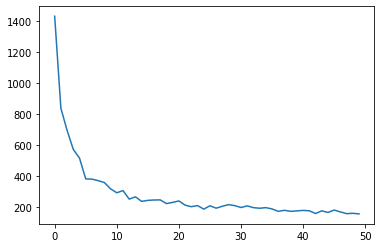

In [10]:
# -----------
# Test Cell
# -----------

np.random.seed(0)

num_runs = 10
num_episodes = 50
env_info = {"num_tiles": 8, "num_tilings": 8}
agent_info = {}
all_steps = []

agent = SarsaAgent
env = mountaincar_env.Environment
start = time.time()

for run in range(num_runs):
    if run % 5 == 0:
        print("RUN: {}".format(run))

    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    steps_per_episode = []

    for episode in range(num_episodes):
        rl_glue.rl_episode(15000)
        steps_per_episode.append(rl_glue.num_steps)

    all_steps.append(np.array(steps_per_episode))

print("Run time: {}".format(time.time() - start))

mean = np.mean(all_steps, axis=0)
plt.plot(mean)

# because we set the random seed, these values should be *exactly* the same
assert np.allclose(mean, [1432.5, 837.9, 694.4, 571.4, 515.2, 380.6, 379.4, 369.6, 357.2, 316.5, 291.1, 305.3, 250.1, 264.9, 235.4, 242.1, 244.4, 245., 221.2, 229., 238.3, 211.2, 201.1, 208.3, 185.3, 207.1, 191.6, 204., 214.5, 207.9, 195.9, 206.4, 194.9, 191.1, 195., 186.6, 171., 177.8, 171.1, 174., 177.1, 174.5, 156.9, 174.3, 164.1, 179.3, 167.4, 156.1, 158.4, 154.4])

This result was using 8 tilings with 8x8 tiles on each. Let's see if we can do better, and what different tilings look like. We will also text 2 tilings of 16x16 and 4 tilings of 32x32. These three choices produce the same number of features (512), but distributed quite differently. 

RUN: 0
RUN: 5
RUN: 10
RUN: 15
stepsize: 0.25
Run Time: 118.24164295196533
RUN: 0
RUN: 5
RUN: 10
RUN: 15
stepsize: 0.015625
Run Time: 66.71305680274963
RUN: 0
RUN: 5
RUN: 10
RUN: 15
stepsize: 0.0625
Run Time: 66.30645632743835


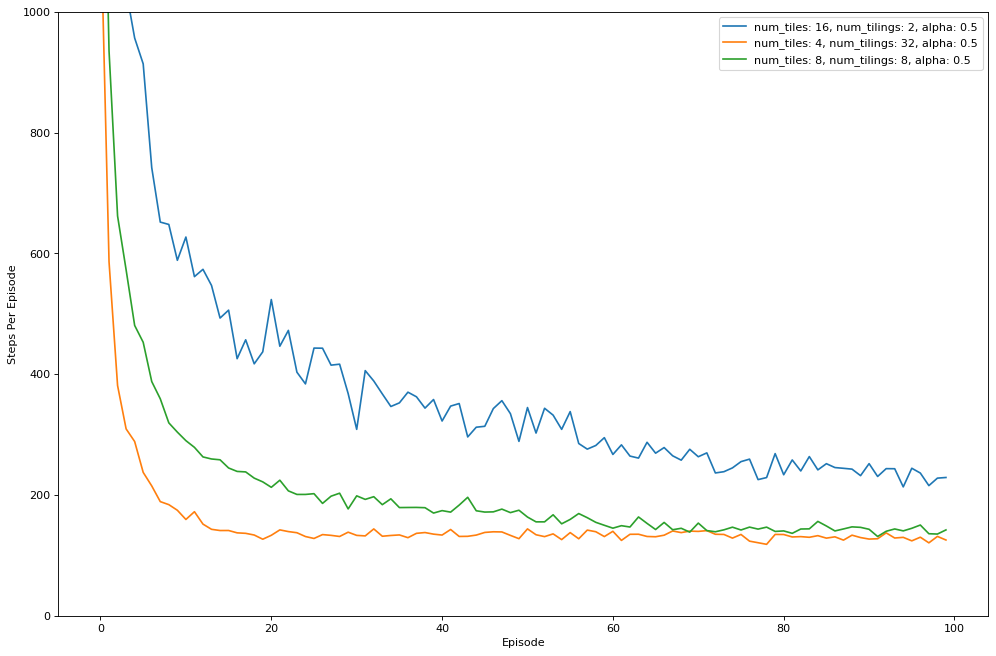

In [11]:
np.random.seed(0)

# Compare the three
num_runs = 20
num_episodes = 100
env_info = {}

agent_runs = []
# alphas = [0.2, 0.4, 0.5, 1.0]
alphas = [0.5]
agent_info_options = [{"num_tiles": 16, "num_tilings": 2, "alpha": 0.5},
                      {"num_tiles": 4, "num_tilings": 32, "alpha": 0.5},
                      {"num_tiles": 8, "num_tilings": 8, "alpha": 0.5}]
agent_info_options = [{"num_tiles" : agent["num_tiles"], 
                       "num_tilings": agent["num_tilings"],
                       "alpha" : alpha} for agent in agent_info_options for alpha in alphas]

agent = SarsaAgent
env = mountaincar_env.Environment
for agent_info in agent_info_options:
    all_steps = []
    start = time.time()
    for run in range(num_runs):
        if run % 5 == 0:
            print("RUN: {}".format(run))
        env = mountaincar_env.Environment
        
        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        steps_per_episode = []

        for episode in range(num_episodes):
            rl_glue.rl_episode(15000)
            steps_per_episode.append(rl_glue.num_steps)
        all_steps.append(np.array(steps_per_episode))
    
    agent_runs.append(np.mean(np.array(all_steps), axis=0))
    print("stepsize:", rl_glue.agent.alpha)
    print("Run Time: {}".format(time.time() - start))

plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(np.array(agent_runs).T)
plt.xlabel("Episode")
plt.ylabel("Steps Per Episode")
plt.yscale("linear")
plt.ylim(0, 1000)
plt.legend(["num_tiles: {}, num_tilings: {}, alpha: {}".format(agent_info["num_tiles"], 
                                                               agent_info["num_tilings"],
                                                               agent_info["alpha"])
            for agent_info in agent_info_options])

####Question: Which strategy works best ?

Answer:

Analysis:

- Blue Line: This strategy starts with a high number of steps per episode and decreases over time, but it remains higher than the other strategies throughout the episodes. This suggests that this configuration is less efficient.

- Orange Line: This strategy shows a rapid decrease in the number of steps per episode and maintains a low number of steps consistently. This indicates that the agent learns quickly and efficiently with this configuration.

- Green Line: This strategy also shows a decrease in the number of steps per episode, but it is not as low as the orange line. It performs better than the blue line but not as well as the orange line.

Conclusion:
The orange line (num_tiles: 4, num_tilings: 32, alpha: 0.5) appears to be the best strategy among the three. It demonstrates the fastest learning rate and the lowest number of steps per episode, indicating that the agent is most efficient with this configuration.

## Section 3: Deep Reinforcement Learning


Now that we have seen a linear function approximator we will move on to a non linear function approximator (neural network)
We will code and train a Deep Q Learning (DQN) agent using PyTorch to play the CartPole-v1 task from [Gymnasium](https://www.gymnasium.farama.org)_.

**Task**

The agent has to decide between two actions - moving the cart left or
right - so that the pole attached to it stays upright. You can find more
information about the environment at
[Gymnasium's website](https://gymnasium.farama.org/environments/classic_control/cart_pole/)_.

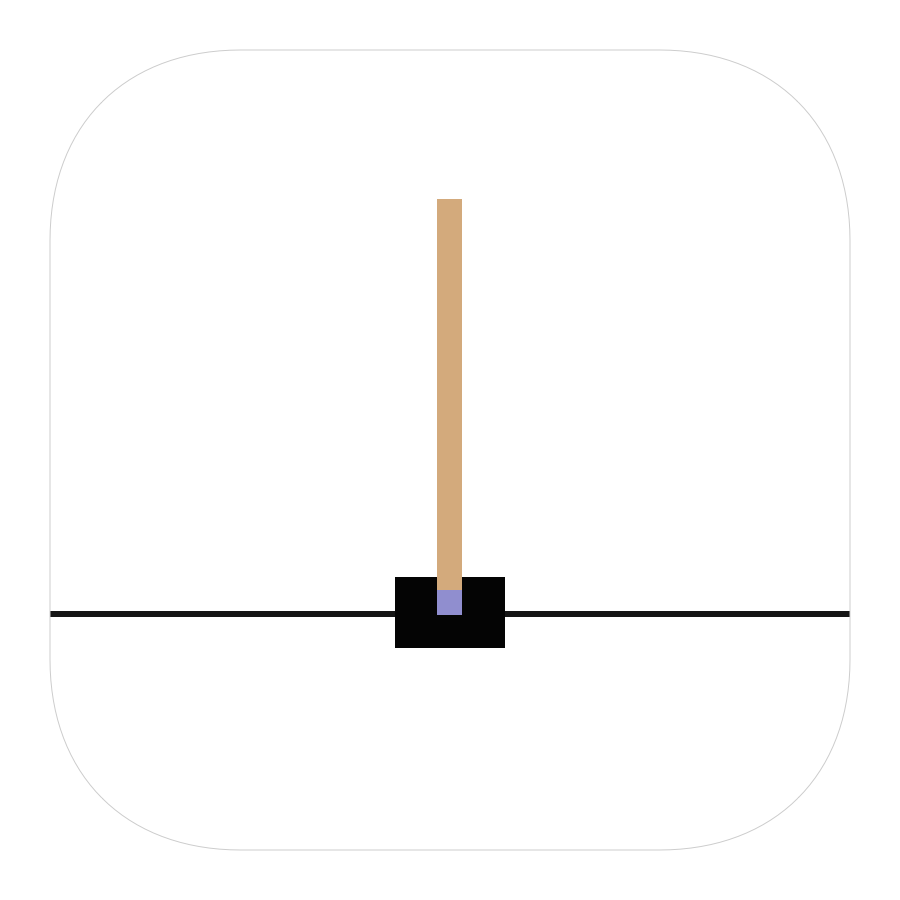

As the agent observes the current state of the environment and chooses
an action, the environment *transitions* to a new state, and also
returns a reward that indicates the consequences of the action. In this
task, rewards are +1 for every incremental timestep and the environment
terminates if the pole falls over too far or the cart moves more than 2.4
units away from center. This means better performing scenarios will run
for longer duration, accumulating larger return.

The CartPole task is designed so that the inputs to the agent are 4 real
values representing the environment state (position, velocity, etc.).
We take these 4 inputs without any scaling and pass them through a 
small fully-connected network with 2 outputs, one for each action. 
The network is trained to predict the expected value for each action, 
given the input state. The action with the highest expected value is then chosen.

For this section, make sure to CHANGE THE RUNTIME TYPE (Runtime -> Change Runtime Type)




In [12]:
%%bash
pip3 install gymnasium[classic_control]

Couldn't find program: 'bash'


We'll also use the following from PyTorch:

-  neural networks (``torch.nn``)
-  optimization (``torch.optim``)
-  automatic differentiation (``torch.autograd``)


In [13]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Replay Memory

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment. It essentially maps (state, action) pairs
   to their (next_state, reward) result, with the state being the
   screen difference image as described later on.
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [14]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Now, let's define our model. But first, let's quickly recap what a DQN is.

### DQN algorithm

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. A lower $\gamma$ makes 
rewards from the uncertain far future less important for our agent 
than the ones in the near future that it can be fairly confident 
about. It also encourages agents to collect reward closer in time 
than equivalent rewards that are temporally far away in the future.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a' Q(s', a))\end{align}

To minimise this error, we will use the [Huber
loss](https://en.wikipedia.org/wiki/Huber_loss)_. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

### Q-network

Our model will be a feed forward  neural network that takes in the
difference between the current and previous screen patches. It has two
outputs, representing $Q(s, \mathrm{left})$ and
$Q(s, \mathrm{right})$ (where $s$ is the input to the
network). In effect, the network is trying to predict the *expected return* of
taking each action given the current input.




In [15]:
# [Graded]
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        # Add a linear layer with input n_observations and output 128
        self.layer1 = nn.Linear(n_observations, 128)
        # Add a linear layer with input 128 and output 128
        self.layer2 = nn.Linear(128, 128)
        # Add a linear layer with input 128 and output n_actions
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))  # Apply ReLU after the first layer
        x = F.relu(self.layer2(x))  # Apply ReLU after the second layer
        return self.layer3(x)       # No activation after the final layer


### Training

#### Hyperparameters and utilities
This cell instantiates our model and its optimizer, and defines some
utilities:

-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
-  ``plot_durations`` - a helper for plotting the durations of episodes,
   along with an average over the last 100 episodes (the measure used in
   the official evaluations). The plot will be underneath the cell
   containing the main training loop, and will update after every
   episode.




In [16]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

# Instantiate the policy network on GPU device
policy_net = DQN(n_observations, n_actions).to(device)
# Instantiate the target network on GPU device
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Training loop

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By definition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network is updated at every step with a 
[soft update](https://arxiv.org/pdf/1509.02971.pdf)_ controlled by 
the hyperparameter ``TAU``, which was previously defined.




In [17]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Below, you can find the main training loop. At the beginning we reset
the environment and obtain the initial ``state`` Tensor. Then, we sample
an action, execute it, observe the next state and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Below, `num_episodes` is set to 600 if a GPU is available, otherwise 50 
episodes are scheduled so training does not take too long. However, 50 
episodes is insufficient for to observe good performance on cartpole.
You should see the model constantly achieve 500 steps within 600 training 
episodes. Training RL agents can be a noisy process, so restarting training
can produce better results if convergence is not observed.




Complete


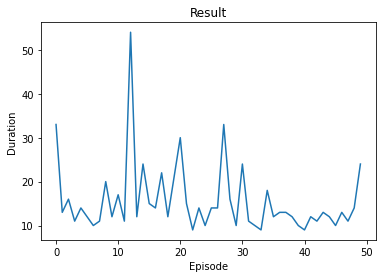

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [18]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

Here is the diagram that illustrates the overall resulting data flow.

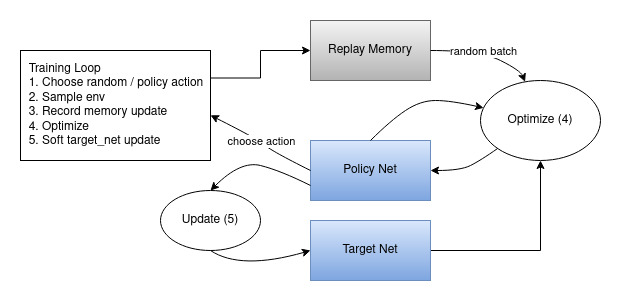

Actions are chosen either randomly or based on a policy, getting the next
step sample from the gym environment. We record the results in the
replay memory and also run optimization step on every iteration.
Optimization picks a random batch from the replay memory to do training of the
new policy. The "older" target_net is also used in optimization to compute the
expected Q values. A soft update of its weights are performed at every step.




## Section 4: Conclusion

Congratulations! You have learned how to implement a control agent using function approximation. In this notebook you learned how to:

- Use function approximation in the control setting
- Implement the Sarsa algorithm using tile coding
- Compare three settings for tile coding to see their effect on our agent
- Implement a DQN for non linear function approximation